## Wikipedia Time Series Analysis
1. Data exploration
2. Model tuning
3. Modeling evaluation and selection
4. Forecasting
5. Conclusion

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import os
import seaborn as sns
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm
import warnings
#ignore the warnings about not having different language fonts available 
warnings.filterwarnings(action='ignore') 

import logging
logger = logging.getLogger('ftpuploader')

### Data Exploration and Processing

In [2]:
#load data and downcast to integers
orig_train = pd.read_csv('/Users/christinejiang/Documents/Python/data/train_1.csv')
key = pd.read_csv('/Users/christinejiang/Documents/Python/data/key_1.csv')
submission = pd.read_csv('/Users/christinejiang/Documents/Python/data/sample_submission_1.csv')
train = orig_train.fillna(0)
for col in train.columns[1:]:
    train[col] = pd.to_numeric(train[col], downcast = 'integer')

In [3]:
def find_lang(page):
    match = re.search('[a-z][a-z].wikipedia.org', page)
    if match:
        return match.group(0)[0:2]
    return 'na'

def find_article(page):
    match = re.search('[a-z][a-z].wikipedia.org.', page)
    if match:
        article_end = match.start()-1
        return(page[0:article_end])
    return 'na'

def find_access(page):
    match = re.search('.*.wikipedia.org.', page)
    if match:
        access_start = match.end()
        return(page[access_start:])
    return 'na'

train['Language'] = train['Page'].map(find_lang)
train['Article'] = train['Page'].map(find_article)
train['Access'] = train['Page'].map(find_access)

In [4]:
dates = train.iloc[:,1:551]
labels = train[['Article','Language','Access','Page']]
newtrain = pd.concat([labels, dates], axis = 1)

display(newtrain.head(2))
#newtrain['Total'] = newtrain.sum(axis=1)
newtrain['Language'].value_counts().sort_values(ascending=False)

,Article,Language,Access,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,all-access_spider,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,...,32,63,15,26,14,20,22,19,18,20
1,2PM,zh,all-access_spider,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,...,17,42,28,15,9,30,52,45,26,20


en    24108
ja    20431
de    18547
na    17855
fr    17802
zh    17229
ru    15022
es    14069
Name: Language, dtype: int64

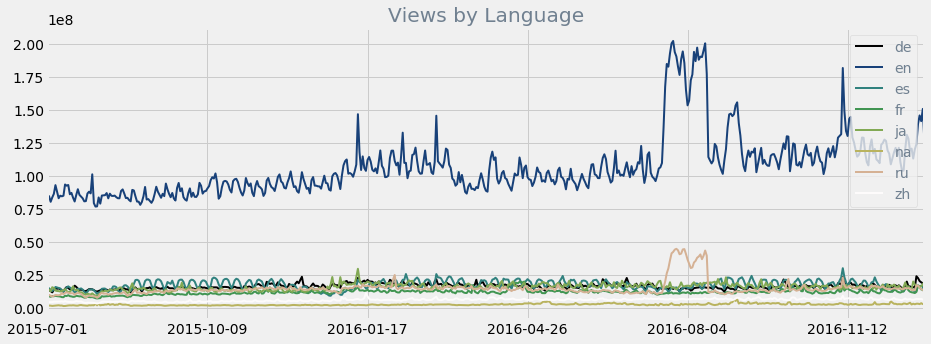

In [5]:
#plot the total views per language
def plot_groups(df, groupby):
    plt.style.use('fivethirtyeight')
    group = df.groupby(groupby).sum().reset_index()
    transpose = group.T
    transpose = transpose.rename(columns = transpose.iloc[0]).drop(transpose.index[0])
    figure = transpose.plot(figsize=(14,5), use_index = True, colormap = "gist_earth", lw=2)
    title=plt.title('Views by '+str(groupby), color='slategray')
    plt.legend(loc='upper left')
    plt.setp(plt.legend().get_texts(), color='slategray')
    return transpose

transposed = plot_groups(newtrain.iloc[:,:-1], 'Language')

In [6]:
#get random indices to plot
languages = newtrain['Language'].unique()
indices = np.random.randint(1,1400,size=3)
num_results = len(indices)
print(indices)

[ 819 1383  459]


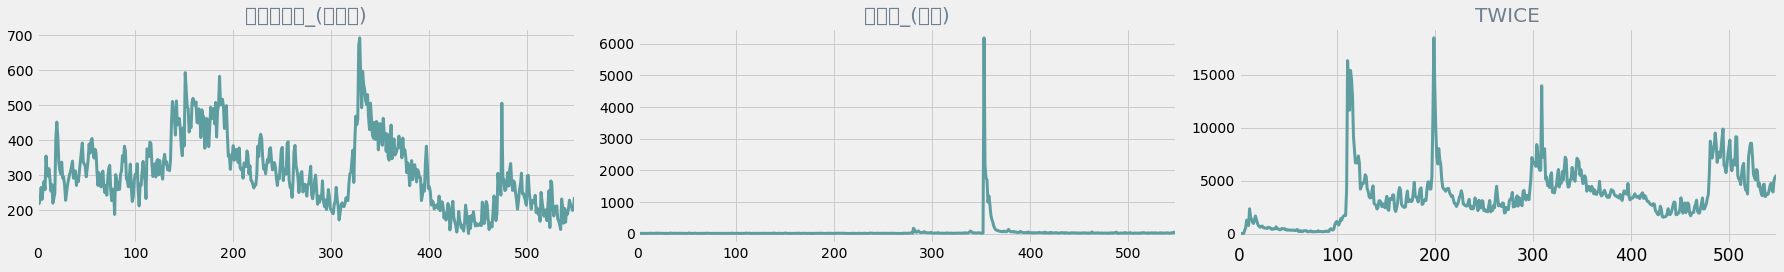

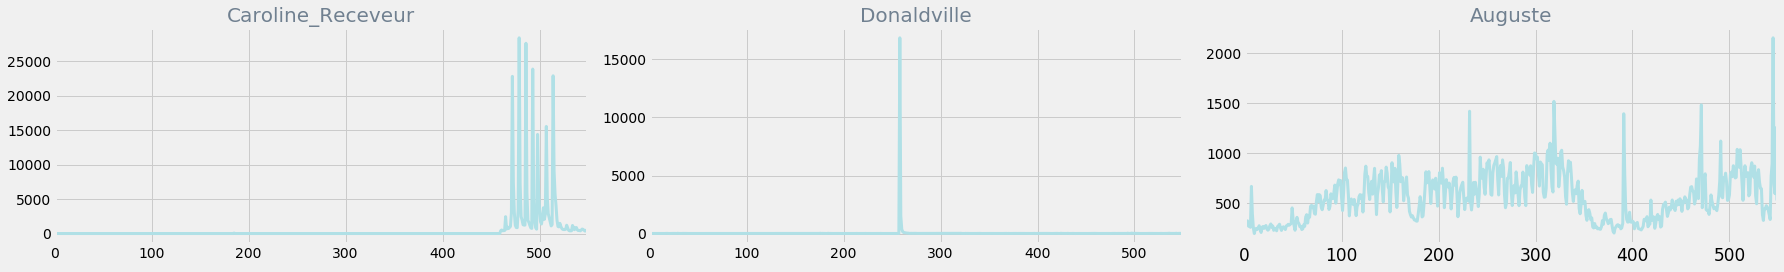

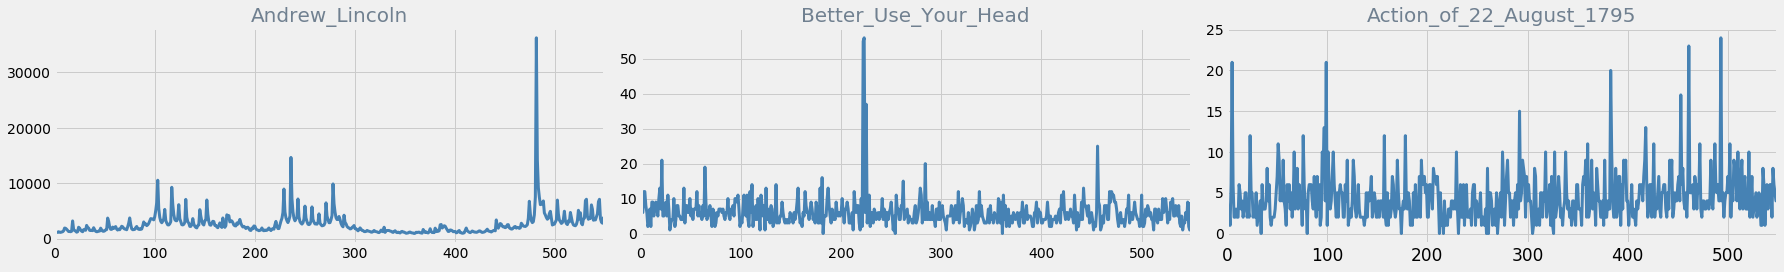

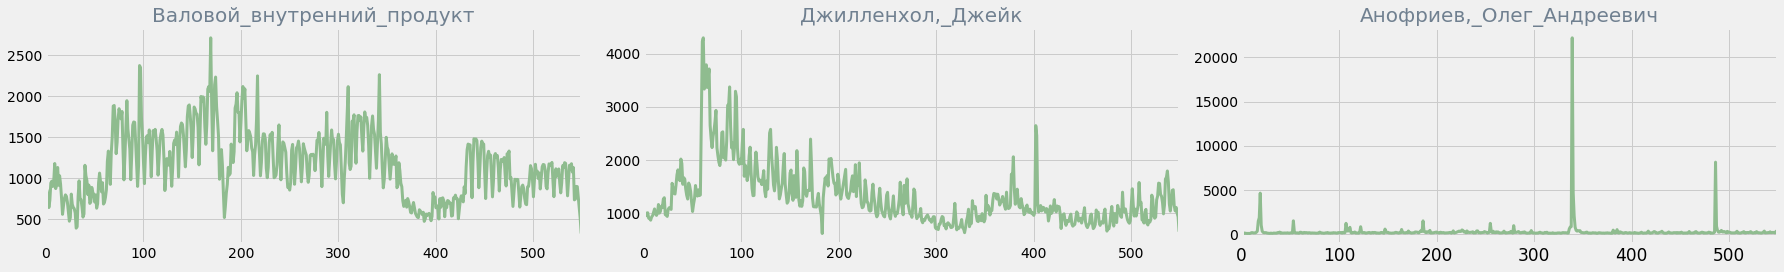

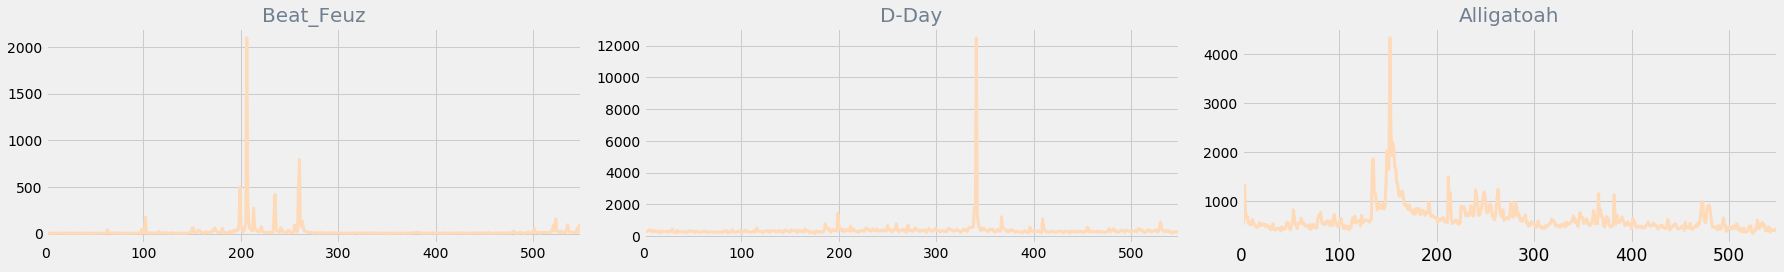

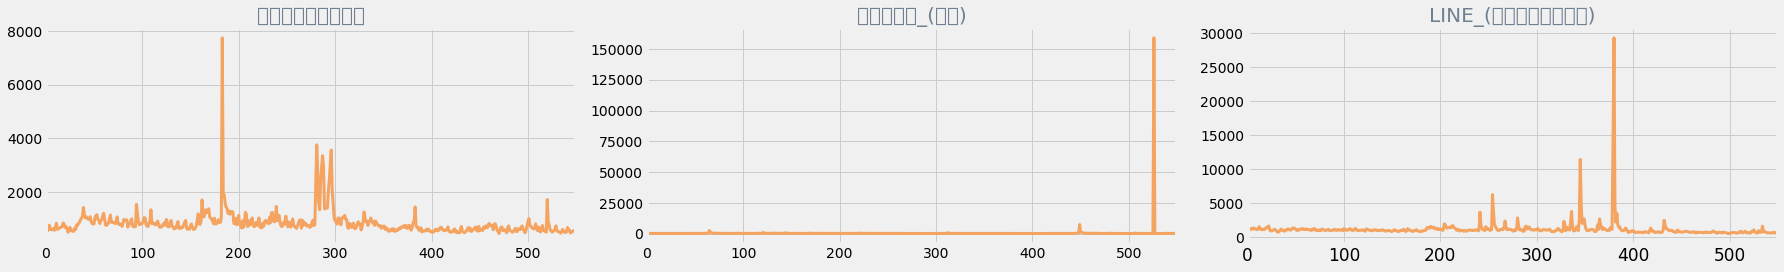

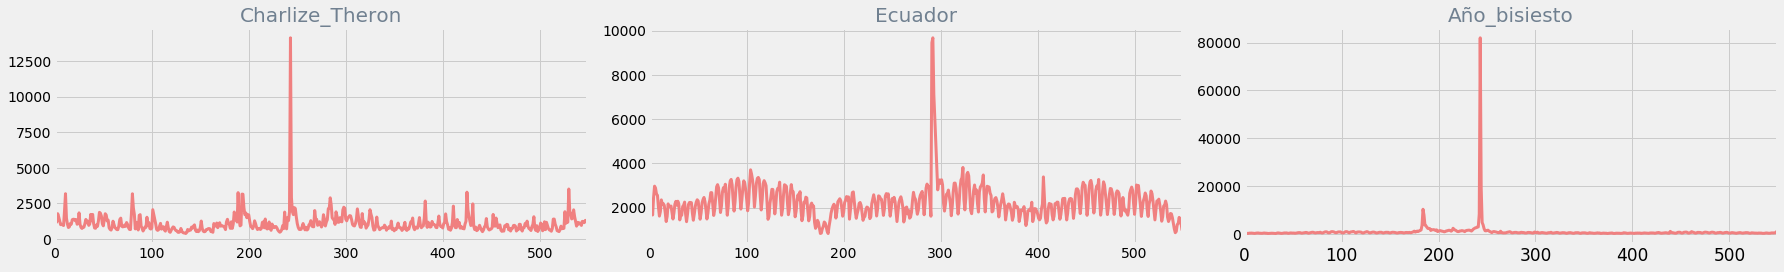

In [7]:
#plot a sample of pages for each language
colors = ['cadetblue','powderblue','steelblue','yellowgreen','darkseagreen','peachpuff','sandybrown','lightcoral']
dataframedict = {}
for i,language in enumerate(languages):
    dataframedict[language] = newtrain[newtrain['Language']==language]
    if language != 'na':
        langcolor = colors[i]
        fig, subaxes = plt.subplots(1,num_results,figsize=[25,4])
        pivottable = dataframedict[language].pivot_table(columns='Article')
        for i, index in enumerate(indices):
            singlerecord = pivottable.iloc[:,index]
            plt.xticks(fontsize=17)
            sns.tsplot(singlerecord,ax = subaxes[i],color=langcolor, linewidth=3)
            subaxes[i].set_title(singlerecord.name, color='slategray')
            subaxes[i].title.set_size(20)
            #fig.suptitle(language)
            plt.tight_layout()
    dataframedict[language]['Total'] = dataframedict[language].sum(axis=1)


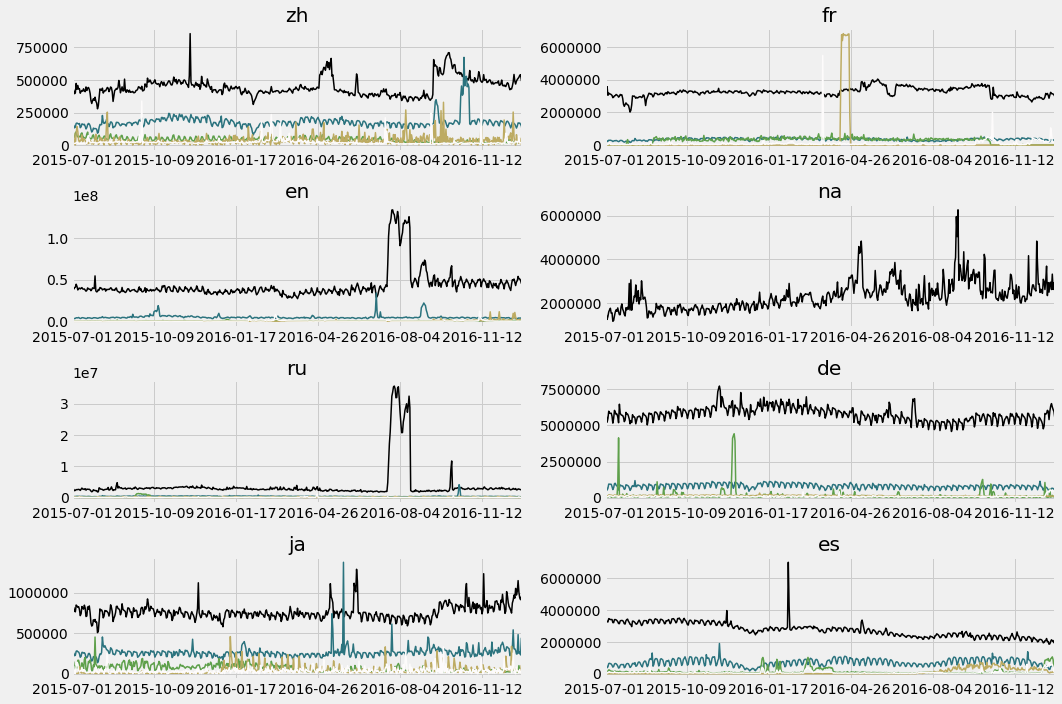

In [8]:
#plot top 5 pages for every language
fig, subaxes = plt.subplots(4,2,figsize=(15,10))
subaxes = subaxes.flatten()
x = [[a,b] for a in range(0,4) for b in range(0,2)]
for i,language in enumerate(languages):
    total_hits = dataframedict[language].groupby('Article').sum()
    top5sites = total_hits.nlargest(5, 'Total')
    axis = subaxes[x[i]]
    top5sites.T.iloc[:-1].plot(lw=1.5, ax=subaxes[i], colormap = 'gist_earth')
    subaxes[i].get_legend().remove()
    subaxes[i].set_title(language)
plt.tight_layout()

### Time Series Modeling

In [222]:
class TimeSeries:
    def __init__(self, ts):
        self.ts = ts
        self.df = pd.DataFrame(ts).rename(columns={0:'Hits'})
        self.adf_statistic = self.stationarity_check()[0]
        self.pvalue = self.stationarity_check()[1]
        self.stationary = self.stationarity_check()[2]
        self.train, self.test = self.train_test_split()
        #self.aics = self.arima_model()
        
    def stationarity_check(self):
        ts = self.ts
        stationarity = adfuller(ts)
        adf_statistic = stationarity[0]
        pvalue = stationarity[1]
        if stationarity[0] < stationarity[4]['5%']:
            stationary = True
        else:
            stationary = False
        return adf_statistic, pvalue, stationary
            
    def plot_diffs(self):
        plt.style.use('fivethirtyeight')
        ts = self.ts
        fig, axes = plt.subplots(3,3,figsize=(18,10))
        axes = axes.reshape(9,)
        for i in range(0,3):
            if i == 0:
                ts.plot(ax=axes[0], lw=2)
                plot_acf(ts, ax=axes[1])
                plot_pacf(ts, ax=axes[2])
                axes[0].set_title('Original Series')
            if i > 0:
                lag = ts.diff(i)
                axis_start = i**2+2
                lag.plot(ax=axes[axis_start], lw=2)
                plot_acf(lag[i:], ax=axes[axis_start+1])
                plot_pacf(lag[i:], ax=axes[axis_start+2])
                axes[axis_start].set_title('Lag of '+str(i))
            plt.tight_layout()
            
    def plot_rolling(self, n=12):
        ts = self.ts
        fig, axes = plt.subplots(1,figsize=(10,4))
        ts.rolling(n).std().plot(color='darkseagreen', ax=axes, lw=2)
        ts.plot(ax=axes, color='lightcoral', lw=2)
        ts.rolling(n).mean().plot(ax=axes, lw=2)
        plt.title('Time Series with Rolling Statistics')
        legend = axes.legend(['Rolling Std.','Original','Rolling Avg.'])
        
    def decompose(self, zoom=True):
        ts = self.ts
        #plt.style.use('seaborn')
        mul_result = seasonal_decompose(ts, model = 'multiplicative', period=7)
        plt.rcParams['figure.figsize'] = (10,4)
        fig = mul_result.plot().suptitle('Multiplicative')
        add_result = seasonal_decompose(ts, model = 'additive', period=7)
        #fig2 = add_result.plot().suptitle('Additive')
        if zoom:
            df = mul_result.seasonal.to_frame()
            df['day'] = df.index.day_name()
            df.index = df['day']
            df.drop('day',axis=1,inplace=True)
            fig = df[0:15].plot(kind='bar', figsize=(10,4), color='darkseagreen') 
            plt.title('Seasonal Trend')
            fig.get_legend().remove()
        return mul_result, add_result
            
    def train_test_split(self, test_split=0.75):
        df = self.df
        marker = int(df.shape[0]*test_split)
        train = df.iloc[0:marker]
        test = df.iloc[marker:]
        return train, test
    
    def arima_model(self, pdq_max=4):
        train = self.train
        p=q=d=range(0,pdq_max)
        pdq = list(itertools.product(p,d,q))
        aics = {}
        best_aic = 9999
        for param in pdq:
            try:
                arima = ARIMA(train, order = param).fit()
                aics[param] = arima.aic
            except Exception as e: 
                aics[param] = e
                continue
        return aics
    
    def model_results(self,p,d,q):
        df = self.df
        train = self.train
        test = self.test
        arima = ARIMA(train, order = (p,d,q)).fit()
        display(arima.summary())
        
        predicted = arima.forecast(test.shape[0])[0]
        squarederror = mean_squared_error(test, predicted)
        mean_error = np.sqrt(squarederror)
        display(mean_error)
    
        predictions = arima.predict(start=d, end=599, typ='levels')
        fig = predictions.plot(lw=2, color ='darkseagreen')
        train.plot(lw=2, ax=fig, color ='lightcoral')
        test.plot(lw=3, ax=fig, color ='powderblue')

In [223]:
#function to make a dataframe for any article
def make_df(article):
    totals = newtrain[newtrain['Article']==article].sum()
    rows = totals[4:-1].astype(float)
    rows.index = pd.DatetimeIndex(rows.index)
    return rows

#create timeseries object
myseries = make_df('United_Nations')
timeseries = TimeSeries(myseries)

adf: -2.7801343721467404, 
p-value: 0.06116794036790202,
stationary: False


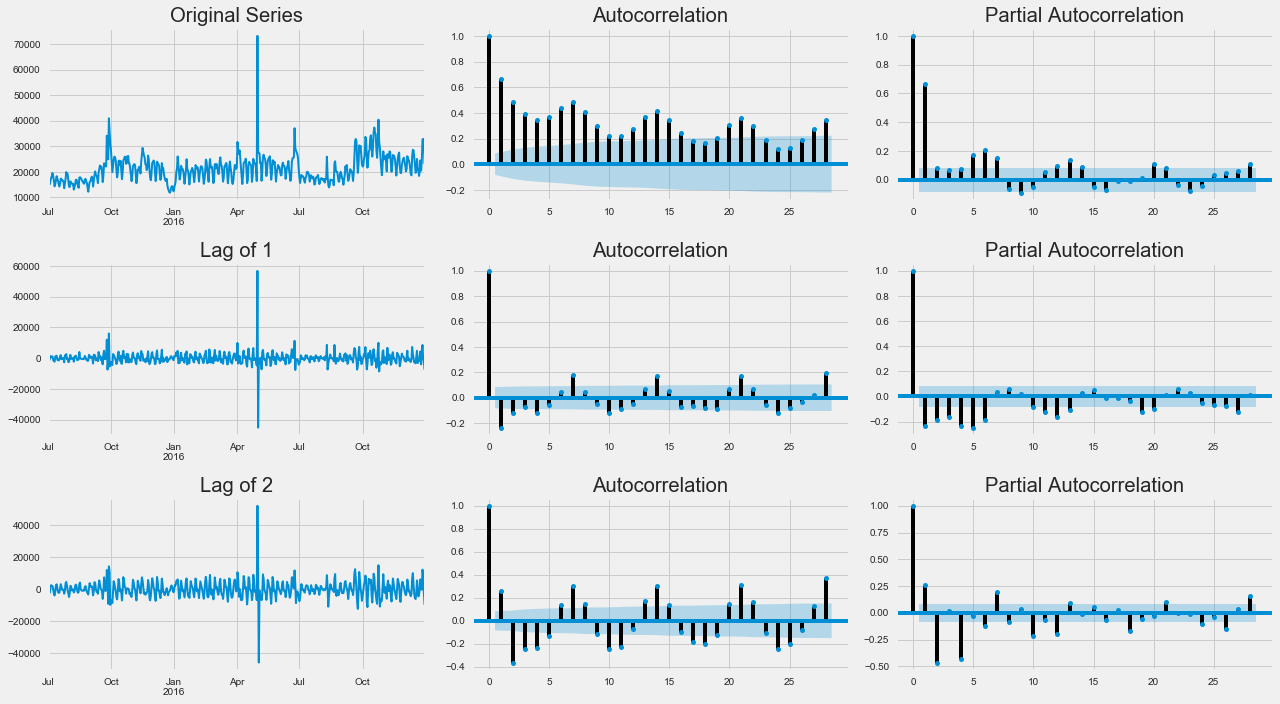

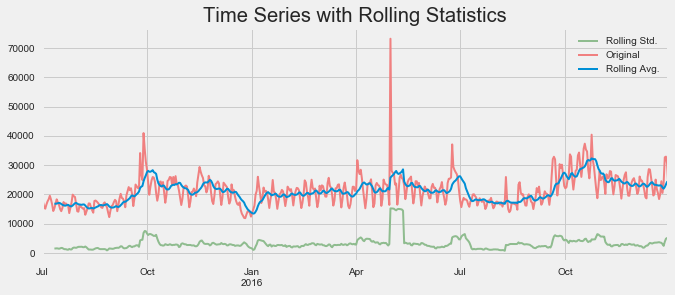

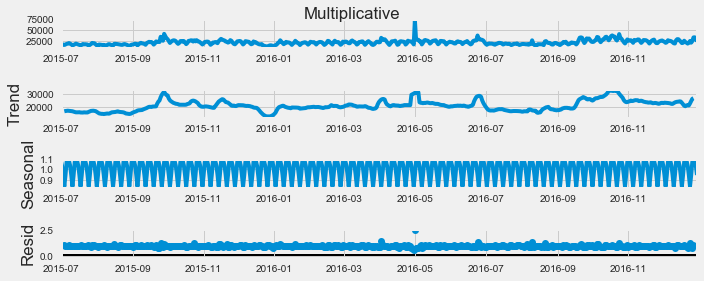

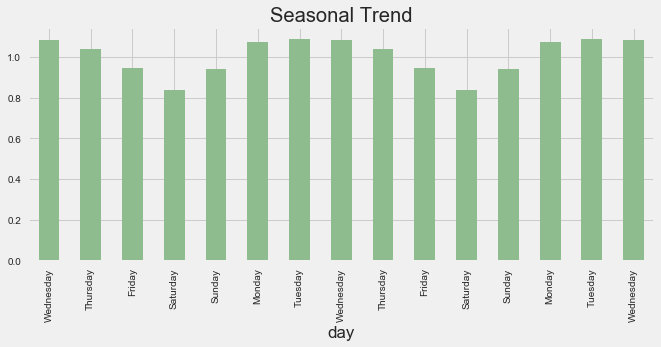

In [224]:
#call each method on the object
adf_statistic, pvalue, stationary = timeseries.stationarity_check()
print(f'''adf: {adf_statistic:}, 
p-value: {pvalue},
stationary: {stationary}''')

timeseries.plot_diffs()
timeseries.plot_rolling()
mul, add = timeseries.decompose()

In [14]:
#to do:
#implement median and average forecasts
#implement evaluation metrics function: mean error, mape, aic
#implement way to plot top 3 models
#understand SARIMA?
#use auto_arima?
#plot the residuals - constant mean and variance, plot kde plot to make sure normally distributed
#plot the frequency for days of the week

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima = SARIMAX(order=(1, 1, 1), seasonal_order=(0, 1, 2, 7), endog=english).fit()
predictions, confint = sarima.predict(start=2, end=700, return_conf_int=True)

fitted_series = pd.Series(predictions, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

predictions.plot()
plt.fill_between(lower_series.index, lower_series, upper_series, color='k')
english.plot()

ValueError: too many values to unpack (expected 2)

In [ ]:
sarima.predict(start=2, end=700, return_conf_int=True)


In [ ]:
import pmdarima as pm


model = pm.auto_arima(english, start_p=1, start_q=1, test='adf', max_p=3, max_q=3,d=None, error_action='ignore',
                     suppress_warnings=True)

model2 = pm.auto_arima(english, start_p=1, start_q=1, test='adf', max_p=3, max_q=3,d=None, D=1, error_action='ignore',
                     suppress_warnings=True, seasonal = True, m=7)

In [ ]:
predictions, confint = model2.predict(100, return_conf_int=True)
index_of_fc = pd.date_range(english.index[-1],periods=100)
fitted_series = pd.Series(predictions, index = index_of_fc)
lower_series = pd.Series(confint[:, 0], index = index_of_fc)
upper_series = pd.Series(confint[:, 1], index = index_of_fc)
fig = plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
predictions = pd.Series(predictions, index = index_of_fc)

plt.plot(predictions)
plt.plot(english)